fsdfsdf

## Data Download

In [166]:
import requests
import pandas as pd

In [167]:
BASE_URL = "http://10.20.20.102:8005"
TIME_RANGE = "30d"

In [168]:
def load_metrics(metric_name: str, range: str):
    # load from prometheus API
    url = f"{BASE_URL}/api/v1/query?query={metric_name}[{range}]"
    response = requests.get(url)
    if response.status_code != 200:
        return None
    
    # load into pandas dataframe
    data = response.json()['data']['result'][0]['values']
    df = pd.DataFrame(data, columns=['timestamp', 'value'])

    # parse datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s', utc=True)
    df["value"] = df["value"].astype(float)
    df = df.assign(name=metric_name)

    return df

In [169]:
# download from prometheus
download_speed = load_metrics('speedtest_download_bits_per_second', TIME_RANGE)
upload_speed   = load_metrics('speedtest_upload_bits_per_second', TIME_RANGE)

# create single dataframe
df = pd.concat([download_speed, upload_speed])

In [170]:
df.head()

,timestamp,value,name
0,2023-05-01 04:40:46.320000+00:00,24199472.0,speedtest_download_bits_per_second
1,2023-05-01 05:40:46.321000192+00:00,22518976.0,speedtest_download_bits_per_second
2,2023-05-01 06:40:46.321000192+00:00,24287568.0,speedtest_download_bits_per_second
3,2023-05-01 07:40:46.321000192+00:00,24375656.0,speedtest_download_bits_per_second
4,2023-05-01 08:40:46.321000192+00:00,23379304.0,speedtest_download_bits_per_second


In [171]:
# convert to Jakarta timezone
df["timestamp"] = df["timestamp"].dt.tz_convert('Asia/Jakarta')
df["timestamp"] = pd.to_datetime(df["timestamp"].dt.strftime('%Y-%m-%d %H:00'))

# convert bps to Mbps
df["value"] = df["value"] / 1000000

# limit to 2023-05-14
df = df[df["timestamp"] < "2023-05-15"]

In [172]:
# save
df.to_csv("indihome_raw.csv", index=None)

## Visualisasi

In [173]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [174]:
df.pivot_table(index='timestamp', columns='name', values='value', margins=True)

name,speedtest_download_bits_per_second,speedtest_upload_bits_per_second,All
timestamp,,,
2023-05-01 11:00:00,24.199472,10.272168,17.235820
2023-05-01 12:00:00,22.518976,10.386192,16.452584
2023-05-01 13:00:00,24.287568,10.304112,17.295840
2023-05-01 14:00:00,24.375656,10.465504,17.420580
2023-05-01 15:00:00,23.379304,10.662784,17.021044
...,...,...,...
2023-05-14 20:00:00,23.547544,10.194136,16.870840
2023-05-14 21:00:00,23.837776,10.339824,17.088800
2023-05-14 22:00:00,14.726208,10.345608,12.535908


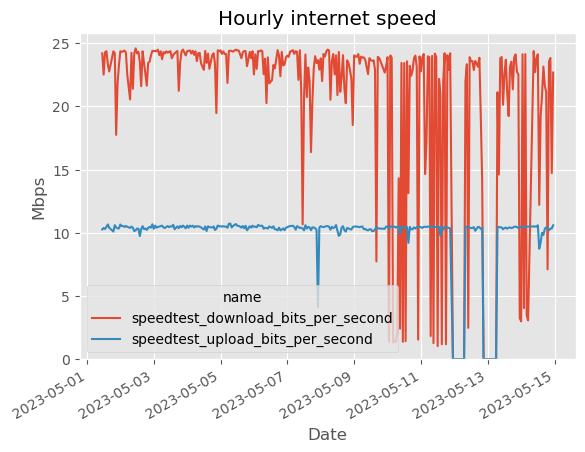

In [175]:
fig, ax = plt.subplots()
df.pivot_table(index='timestamp', columns='name', values='value').plot(title="Hourly internet speed", ax=ax)

ax.set_ylabel("Mbps")
ax.set_xlabel("Date")
ax.set_ylim(bottom=0)
plt.show()

In [176]:
# drop zeros
df_temp = df.copy()
df_temp = df_temp[df_temp["value"] > 0.0]

# create pivot table
df_pivot = df_temp.pivot_table(index='timestamp', columns='name', values='value').reset_index()
df_pivot = df_pivot.set_index('timestamp')

# rename columns
df_pivot = df_pivot.rename(columns={"speedtest_download_bits_per_second": "download_mbps", "speedtest_upload_bits_per_second": "upload_mbps"})

# resample to daily
df_pivot = df_pivot.resample('D').mean()

df_pivot.to_csv("indihome_daily.csv")

df_pivot.head()

name,download_mbps,upload_mbps
timestamp,,
2023-05-01,22.993512,10.393680
2023-05-02,23.491832,10.386742
2023-05-03,24.076764,10.471725
2023-05-04,23.796836,10.451939
2023-05-05,24.123063,10.511218


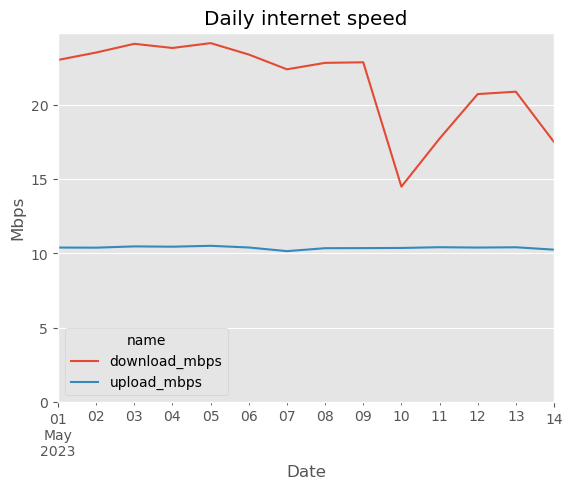

In [177]:
fig, ax = plt.subplots()
df_pivot.plot(title="Daily internet speed", ax=ax)

ax.set_ylabel("Mbps")
ax.set_xlabel("Date")
ax.set_ylim(bottom=0)
plt.show()

## T-test

In [178]:
from scipy import stats

In [179]:
df_pivot.describe()

name,download_mbps,upload_mbps
count,14.000000,14.000000
mean,21.505166,10.379913
std,2.954165,0.088968
min,14.483851,10.153444
25%,20.741366,10.359570
50%,22.816484,10.393733
75%,23.458043,10.415682
max,24.123063,10.511218


In [180]:
h1_mean = 30
samples = df_pivot['download_mbps'].values
tstat = stats.ttest_1samp(samples, popmean=h1_mean, alternative="two-sided")

print(f"Mean: {samples.mean():.4f}")
print(f"Standard deviation: {samples.std():.4f}")
print(f"Sample size: {len(samples)}")
print(f"Mean difference: {samples.mean() - h1_mean:.4f}")
print("")
print(f"p-value: {tstat.pvalue:.4f}")
print(f"t-statistic: {tstat.statistic:.4f}")
print(f"df: {tstat.df}")
print(tstat.confidence_interval(0.95))

Mean: 21.5052
Standard deviation: 2.8467
Sample size: 14
Mean difference: -8.4948

p-value: 0.0000
t-statistic: -10.7593
df: 13
ConfidenceInterval(low=19.79948165148948, high=23.21085036715489)


In [181]:
monthly_bill = 366000
loss = monthly_bill - (monthly_bill / h1_mean * samples.mean() )
print(f"Loss: {loss:,}") 

Loss: 103,636.97468626936


## OLS

In [182]:
from datetime import datetime
import seaborn as sns
import statsmodels.formula.api as smf

In [183]:
df_reg = df_pivot.copy().reset_index()
largest_diff = (pd.to_datetime(datetime.now()) - df_reg["timestamp"]).dt.days.max()

df_reg["timestamp"] = pd.to_datetime(datetime.now()) - df_reg["timestamp"]
df_reg["timestamp"] = largest_diff - df_reg["timestamp"].dt.days

In [184]:
results = smf.ols('download_mbps ~ timestamp', data=df_reg).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          download_mbps   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.438
Method:                 Least Squares   F-statistic:                     11.14
Date:                Mon, 15 May 2023   Prob (F-statistic):            0.00592
Time:                        15:32:26   Log-Likelihood:                -29.915
No. Observations:                  14   AIC:                             63.83
Df Residuals:                      12   BIC:                             65.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.6899      1.123     21.988      0.0

/home/fahmi/.mambaforge/envs/ritsupi/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


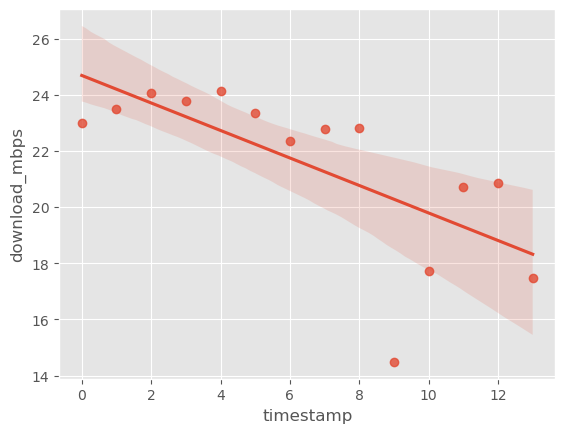

In [185]:
sns.regplot(x="timestamp", y="download_mbps", data=df_reg)
plt.show()

In [186]:
max_days = df_reg["timestamp"].max() - 30
df_pred = pd.DataFrame({"timestamp": [x for x in range(max_days, 30*5)]})
df_pred = df_pred.assign(predicted=results.predict(df_pred))
df_pred.head()

,timestamp,predicted
0,-17,33.019246
1,-16,32.529285
2,-15,32.039324
3,-14,31.549363
4,-13,31.059403


In [187]:
df_all = pd.concat([
  df_reg.drop(columns=["upload_mbps"]).rename(columns={"timestamp": "days", "download_mbps": "value"}), 
  df_pred.rename(columns={"timestamp": "days", "predicted": "value"})
])

first_date = pd.to_datetime(datetime.now()) - pd.Timedelta(days=largest_diff)
df_all["date"] = df_all["days"].apply(lambda d: pd.Timedelta(days=int(d)) + first_date)

In [188]:
df_all.resample("M", on="date").mean().drop(columns=["days"])

,value
date,
2023-04-30,29.099559
2023-05-31,18.636173
2023-06-30,2.396693
2023-07-31,-12.547113
2023-08-31,-27.735899
2023-09-30,-41.944764
